In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from wordcloud import WordCloud
import re
import unicodedata
import nltk
import csv
from textblob import TextBlob
from nltk.corpus import stopwords
!pip install demoji
nltk.download('all')
import demoji

In [46]:
!git clone https://github.com/sydney-machine-learning/COVID19_sentinentanalysissocialmedia

Cloning into 'COVID19_sentinentanalysissocialmedia'...
remote: Enumerating objects: 156, done.
remote: Counting objects: 100% (156/156), done.
remote: Compressing objects: 100% (147/147), done.
remote: Total 156 (delta 49), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (156/156), 40.00 MiB | 7.53 MiB/s, done.
Resolving deltas: 100% (49/49), done.


In [3]:
demoji.download_codes()

... OK (Got response in 0.54 seconds)
Writing emoji data to /root/.demoji/codes.json ...
... OK


In [4]:
senwave = pd.read_csv("/content/drive/My Drive/Covid 19 India/labeledEn.csv")
print("Length of Senwave Dataset = {}".format(len(senwave)))

Length of Senwave Dataset = 10000


In [5]:
senwave.head(10)

,ID,Tweet,Optimistic,Thankful,Empathetic,Pessimistic,Anxious,Sad,Annoyed,Denial,Official report,Surprise,Joking
0,1.245140e+18,A glass of wine keeps the corona away- DRAKE. ...,1,0,0,0,0,0,0,0,0,0,1
1,1.245140e+18,Can Anyone tell me if you took the flu shot la...,0,0,0,0,1,0,0,0,0,1,0
2,1.245140e+18,Btw producers send me beats I’m working on mus...,1,0,0,0,0,0,0,0,0,0,1
3,1.245140e+18,When someone you know.. apart of your family d...,0,0,0,0,0,1,0,0,0,0,0
4,1.245140e+18,"Dear soccer,\nI really miss you ,please come b...",0,0,0,0,0,1,1,0,0,0,0
5,1.245140e+18,new home remedy to treat coronavirus! tested b...,1,0,0,0,0,0,0,1,0,0,1
6,1.245140e+18,When Xavier Wulf does an Attack on Titan tape ...,0,0,0,0,0,0,0,0,0,0,1
7,1.245140e+18,Mouthwash is hand san for your mouth and I don...,0,0,0,0,0,1,0,0,0,1,1
8,1.245140e+18,@Sandykikimunch2 @Thomas1774Paine Yes all of t...,0,0,0,0,0,0,1,0,1,1,0
9,1.245140e+18,Update I destroyed the tire 😔 honestly if I ge...,0,0,0,1,0,1,0,0,0,0,0


Text(0.5, 0, 'Count')

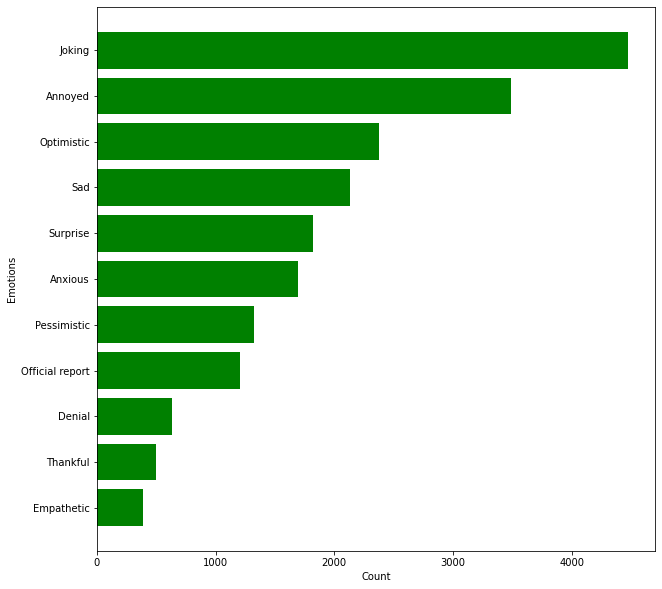

In [6]:
emotions = list(senwave.columns[2:])
scores = [sum(senwave[x]) for x in emotions]
pairs = []

for i in range(len(emotions)):
    pairs.append((emotions[i], scores[i]))

pairs = sorted(pairs, key = lambda x : x[1], reverse = False)
emotions_sorted = []
scores_sorted = []

for pair in pairs:
    emotions_sorted.append(pair[0])
    scores_sorted.append(pair[1])

fig = plt.figure(figsize = (10, 10))
plt.barh(emotions_sorted, scores_sorted, color = 'green')
plt.ylabel("Emotions")
plt.xlabel("Count")

In [7]:
rand_idx = np.random.randint(0, len(senwave))
print("Tweet : ", senwave.iloc[rand_idx]['Tweet'])
for e in emotions:
    print(e, ": ", senwave.iloc[rand_idx][e])

Tweet :  Antarctica remains the only continent in the world where the coronavirus hasn't arrived so far.
Optimistic :  1
Thankful :  0
Empathetic :  0
Pessimistic :  0
Anxious :  0
Sad :  0
Annoyed :  0
Denial :  0
Official report :  0
Surprise :  1
Joking :  0


In [8]:
only_emotes = senwave[emotions]

In [9]:
only_emotes

,Optimistic,Thankful,Empathetic,Pessimistic,Anxious,Sad,Annoyed,Denial,Official report,Surprise,Joking
0,1,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,1,0,0,0,0,1,0
2,1,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,1,0,0,0,0,0
4,0,0,0,0,0,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
9995,1,0,0,0,0,0,0,0,0,0,1
9996,1,1,0,0,1,0,0,0,0,0,0
9997,0,0,0,0,0,0,0,0,0,1,0
9998,1,0,0,1,0,0,0,0,0,0,1


In [10]:
only_emotes.iloc[0].tolist()

[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]

In [11]:
emote_array = np.zeros((11, 11))
e2i = {
    'Optimistic' : 0, 'Thankful' : 1, 'Empathetic' : 2, 'Pessimistic' : 3, 'Anxious' : 4, 'Sad' : 5, 'Annoyed' : 6, 'Denial' : 7, 'Official report' : 8,
    'Surprise' : 9, 'Joking' : 10
}
for i in range(len(only_emotes)):
    l = only_emotes.iloc[i].tolist()
    for j in range(11):
        if l[j] == 1:
            emote_array[j][j] += 1
        for k in range(j+1, 11):
            if (l[j] == 1) and (l[k] == 1):
                emote_array[j][k] += int(1)
                emote_array[k][j] += int(1)

In [12]:
emote_df = pd.DataFrame(emote_array, columns = emotions)
for col in emote_df:
    emote_df[col] = emote_df[col].astype(int)
emote_df

,Optimistic,Thankful,Empathetic,Pessimistic,Anxious,Sad,Annoyed,Denial,Official report,Surprise,Joking
0,2373,235,171,226,246,291,379,72,156,387,982
1,235,498,28,15,41,29,67,14,70,98,92
2,171,28,389,18,50,71,41,7,7,24,63
3,226,15,18,1325,268,272,420,90,62,264,554
4,246,41,50,268,1695,360,452,95,138,357,510
5,291,29,71,272,360,2133,723,54,186,299,747
6,379,67,41,420,452,723,3492,261,122,536,1235
7,72,14,7,90,95,54,261,631,51,201,184
8,156,70,7,62,138,186,122,51,1207,284,95
9,387,98,24,264,357,299,536,201,284,1820,612


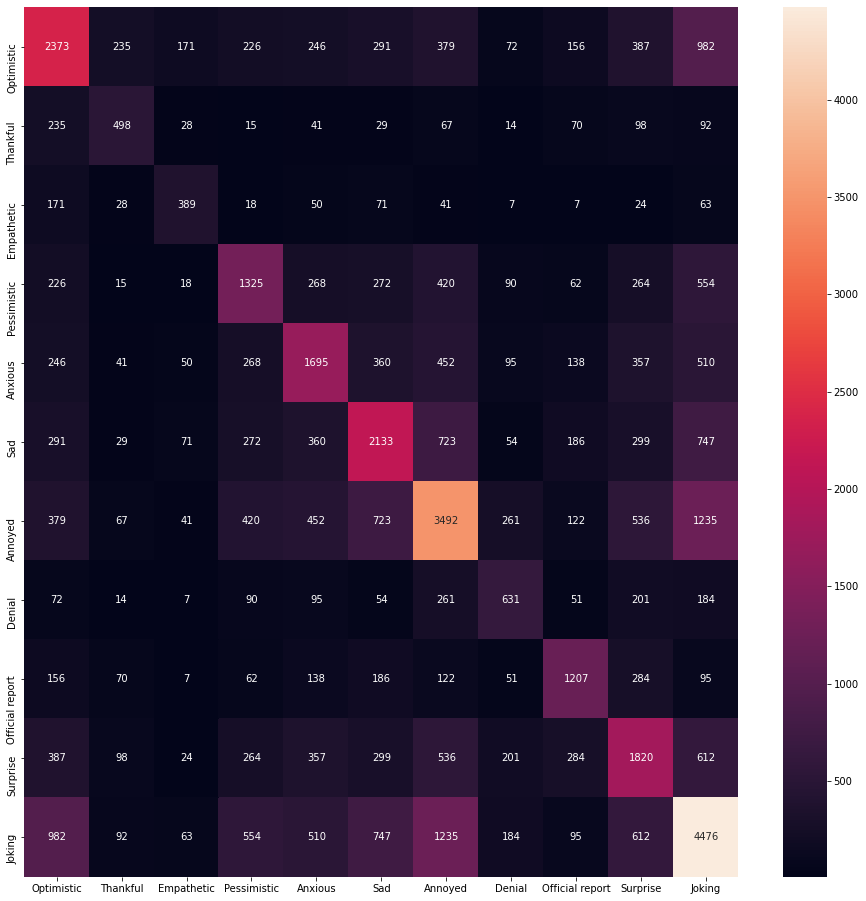

In [13]:
fig = plt.figure(figsize = (16,16))
sns.heatmap(emote_df, annot = True, xticklabels = emote_df.columns, yticklabels = emote_df.columns, fmt = 'g')

Inferences:
*   We see that around 1000 people who were being optimistic also had a joke emotion attached to their tweet.
* Around 390 of the people who were being positive also had a surprise attached to their tweet. It could be probably because of some good news they weren't expecting.
* Pessimistic tweets usually were of joking nature or were displaying their annoyance.
*   When people were being thankful, it was usually towards the Government or God or People in general and therefore it made them optimistic for the future (about 240)
* About 1200 of the people who were annoyed were also joking. Displaying your annoyance through jokes never goes out of style.
* About 780 of the 2100 tweets which were sad were jokes, i.e. people were trying to drown their sadness through laughter.


# **WORD CLOUDs**

**Optimism**

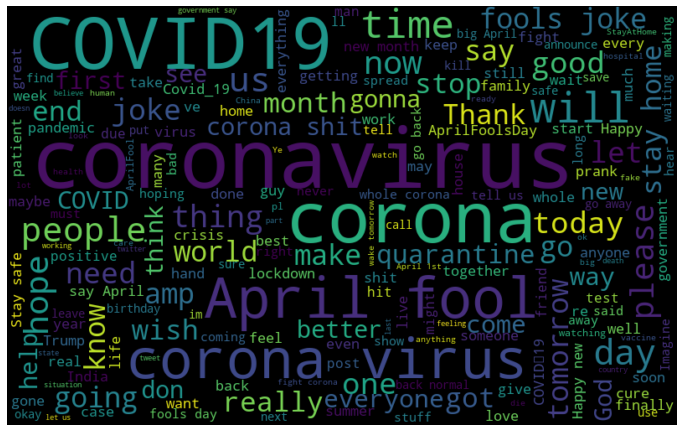

In [14]:
optimisticWords = " ".join([word for word in senwave['Tweet'][senwave['Optimistic'] == 1]])
wc = WordCloud(width = 800, height = 500, max_font_size = 100).generate(optimisticWords)
plt.figure(figsize = (12, 8))
plt.imshow(wc, interpolation = 'bilinear')
plt.axis('off')
plt.show()

**Thankful**

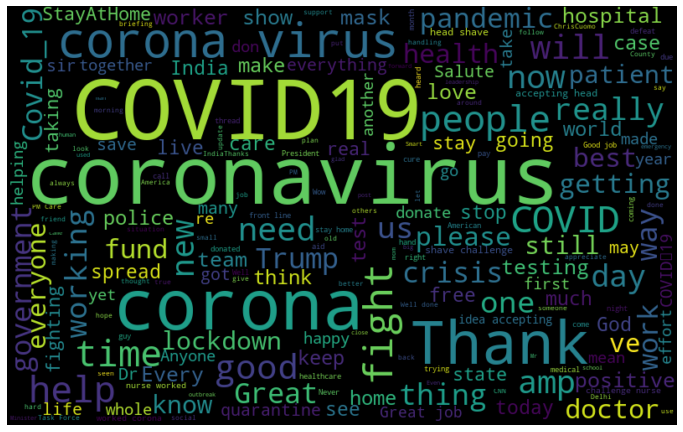

In [15]:
thankfulWords = " ".join([word for word in senwave['Tweet'][senwave['Thankful'] == 1]])
wc = WordCloud(width = 800, height = 500, max_font_size = 100).generate(thankfulWords)
plt.figure(figsize = (12, 8))
plt.imshow(wc, interpolation = 'bilinear')
plt.axis('off')
plt.show()

**Empathy**

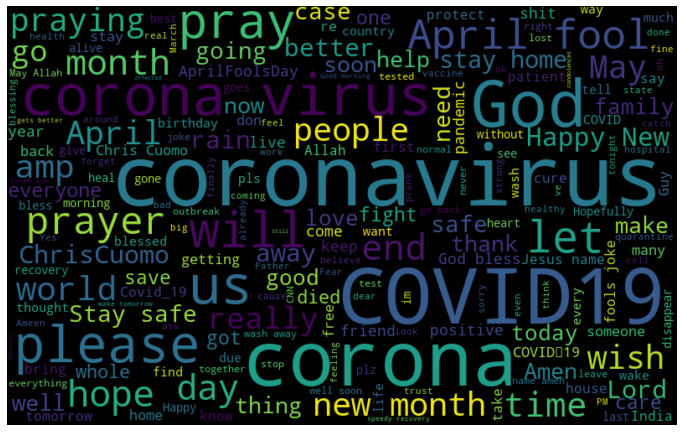

In [16]:
empatheticWords = " ".join([word for word in senwave['Tweet'][senwave['Empathetic'] == 1]])
wc = WordCloud(width = 800, height = 500, max_font_size = 100).generate(empatheticWords)
plt.figure(figsize = (12, 8))
plt.imshow(wc, interpolation = 'bilinear')
plt.axis('off')
plt.show()

**Anxiety**

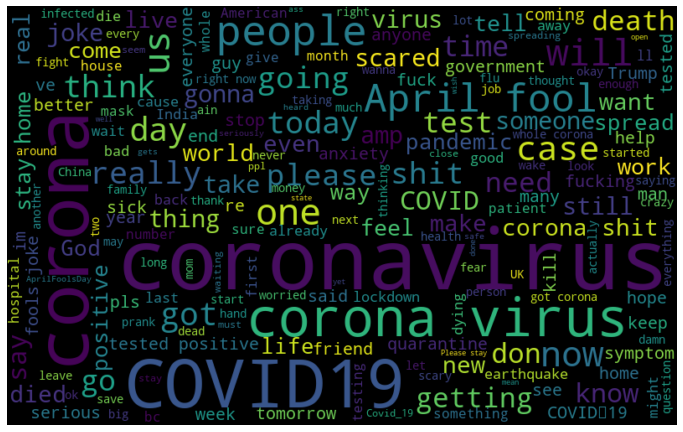

In [17]:
anxiousWords = " ".join([word for word in senwave['Tweet'][senwave['Anxious'] == 1]])
wc = WordCloud(width = 800, height = 500, max_font_size = 100).generate(anxiousWords)
plt.figure(figsize = (12, 8))
plt.imshow(wc, interpolation = 'bilinear')
plt.axis('off')
plt.show()

**Sad**

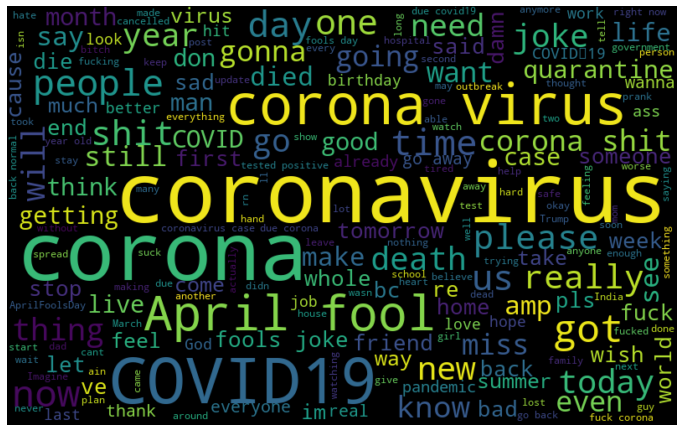

In [18]:
sadWords = " ".join([word for word in senwave['Tweet'][senwave['Sad'] == 1]])
wc = WordCloud(width = 800, height = 500, max_font_size = 100).generate(sadWords)
plt.figure(figsize = (12, 8))
plt.imshow(wc, interpolation = 'bilinear')
plt.axis('off')
plt.show()

**Official Report**

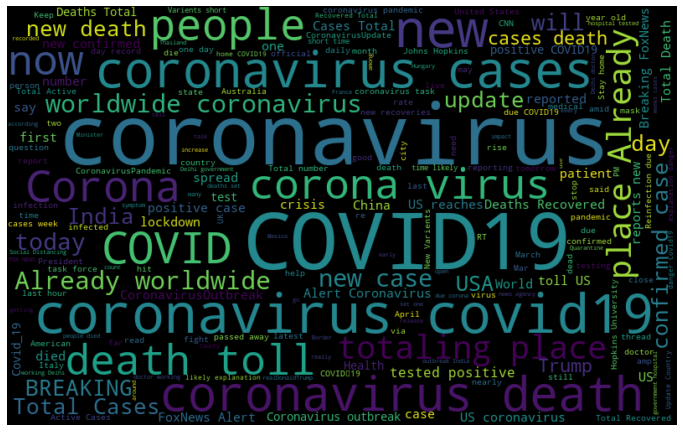

In [19]:
ORWords = " ".join([word for word in senwave['Tweet'][senwave['Official report'] == 1]])
wc = WordCloud(width = 800, height = 500, max_font_size = 100).generate(ORWords)
plt.figure(figsize = (12, 8))
plt.imshow(wc, interpolation = 'bilinear')
plt.axis('off')
plt.show()

**Joking**

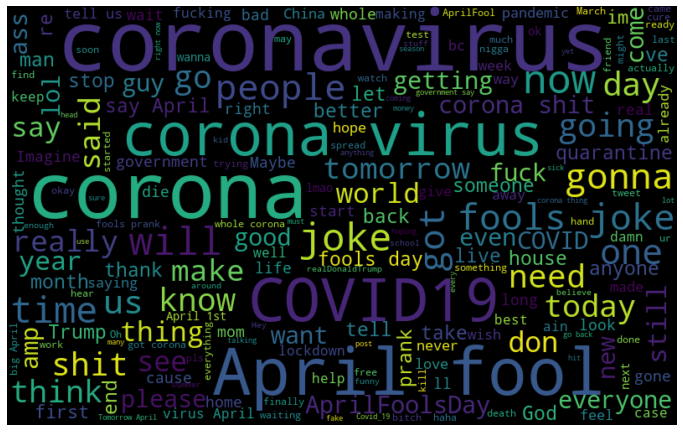

In [20]:
jokeWords = " ".join([word for word in senwave['Tweet'][senwave['Joking'] == 1]])
wc = WordCloud(width = 800, height = 500, max_font_size = 100).generate(jokeWords)
plt.figure(figsize = (12, 8))
plt.imshow(wc, interpolation = 'bilinear')
plt.axis('off')
plt.show()

# **Cleaning followed by Unigram and Bigram analysis**

In [21]:
def clean(text):
    wnl = nltk.stem.WordNetLemmatizer()
    StopWords = stopwords.words('english')
    text = (unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore').lower())
    words = re.sub(r'[^\w\s]', '', text).split()
    return [wnl.lemmatize(word) for word in words if word not in StopWords]

In [22]:
words = clean(''.join(str(senwave['Tweet'].tolist())))

In [23]:
words[:20]

['glass',
 'wine',
 'keep',
 'corona',
 'away',
 'drake',
 'se',
 'diga',
 'ma',
 'cheer',
 'anyone',
 'tell',
 'took',
 'flu',
 'shot',
 'last',
 'year',
 'give',
 'positive',
 'result']

**N-gram analysis**

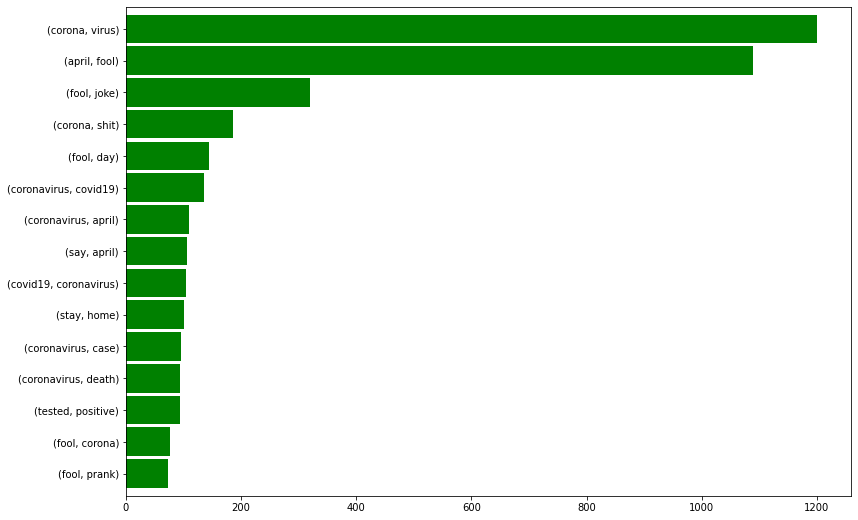

In [24]:
bigrams_series = (pd.Series(nltk.ngrams(words, 2)).value_counts())[:15]
trigrams_series = (pd.Series(nltk.ngrams(words, 3)).value_counts())[:15]

bigrams_series.sort_values().plot.barh(color = 'green', width = 0.9, figsize = (13, 9))

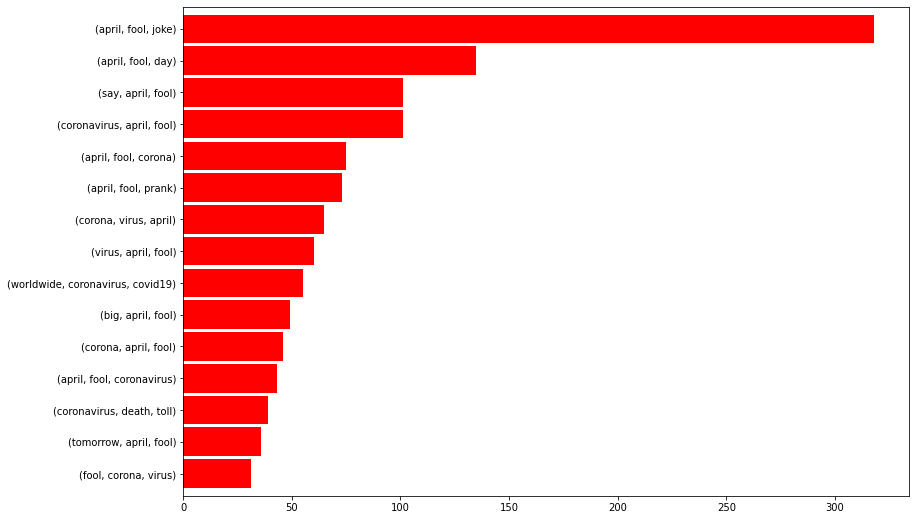

In [25]:
trigrams_series.sort_values().plot.barh(color = 'red', width = 0.9, figsize = (13, 9))

**Preprocessing**

In [26]:
contractions = { 
"ain't": "am not", "aren't": "are not", "can't": "cannot", "can't've": "cannot have", "'cause": "because", "could've": "could have", "couldn't": "could not",
"couldn't've": "could not have", "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hadn't've": "had not have",
"hasn't": "has not", "haven't": "have not", "he'd": "he had", "he'd've": "he would have", "he'll": "he will", "he'll've": "he will have", "he's": "he is",
"how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is", "i'd": "i would", "i'd've": "i would have",
"i'll": "i will", "i'll've": "i will have", "i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
"it'd've": "it would have", "it'll": "it will", "it'll've": "it will have", "it's": "it is", "let's": "let us",
"ma'am": "madam", "mayn't": "may not", "might've": "might have", "mightn't": "might not", "mightn't've": "might not have", "must've": "must have", "mustn't": "must not",
"mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have", "o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have",
"shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she shall / she will",
"she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have",
"so've": "so have", "so's": "so is", "that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
"there'd've": "there would have", "there's": "there is", "they'd": "they would", "they'd've": "they would have", "they'll": "they will",
"they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would",
"we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will",
"what'll've": "what will have", "what're": "what are", "what's": "what is", "what've": "what have", "when's": "when is",
"when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have",
"who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
"would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would", "y'all'd've": "you all would have",
"y'all're": "you all are", "y'all've": "you all have", "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
"you're": "you are", "you've": "you have"
}

In [27]:
contractionsWithAnotherInvertedComma = { 
"ain’t": "am not", "aren’t": "are not", "can’t": "cannot", "can’t’ve": "cannot have", "’cause": "because", "could’ve": "could have", "couldn’t": "could not",
"couldn’t’ve": "could not have", "didn’t": "did not", "doesn’t": "does not", "don’t": "do not", "hadn’t": "had not", "hadn’t’ve": "had not have",
"hasn’t": "has not", "haven’t": "have not", "he’d": "he had", "he’d’ve": "he would have", "he’ll": "he will", "he’ll’ve": "he will have", "he’s": "he is",
"how’d": "how did", "how’d’y": "how do you", "how’ll": "how will", "how’s": "how is", "i’d": "i would", "i’d’ve": "i would have",
"i’ll": "i will", "i’ll’ve": "i will have", "i’m": "i am", "i’ve": "i have", "isn’t": "is not", "it’d": "it would",
"it’d’ve": "it would have", "it’ll": "it will", "it’ll’ve": "it will have", "it’s": "it is", "let’s": "let us",
"ma’am": "madam", "mayn’t": "may not", "might’ve": "might have", "mightn’t": "might not", "mightn’t’ve": "might not have", "must’ve": "must have", "mustn’t": "must not",
"mustn’t’ve": "must not have", "needn’t": "need not", "needn’t’ve": "need not have", "o’clock": "of the clock", "oughtn’t": "ought not", "oughtn’t’ve": "ought not have",
"shan’t": "shall not", "shan’t’ve": "shall not have", "she’d": "she would", "she’d’ve": "she would have", "she’ll": "she will",
"she’ll’ve": "she will have", "she’s": "she is", "should’ve": "should have", "shouldn’t": "should not", "shouldn’t’ve": "should not have",
"so’ve": "so have", "so’s": "so is", "that’d": "that would", "that’d’ve": "that would have", "that’s": "that is", "there’d": "there would",
"there’d’ve": "there would have", "there’s": "there is", "they’d": "they would", "they’d’ve": "they would have", "they’ll": "they will",
"they’ll’ve": "they will have", "they’re": "they are", "they’ve": "they have", "to’ve": "to have", "wasn’t": "was not", "we’d": "we would",
"we’d’ve": "we would have", "we’ll": "we will", "we’ll’ve": "we will have", "we’re": "we are", "we’ve": "we have", "weren’t": "were not", "what’ll": "what will",
"what'll've": "what will have", "what're": "what are", "what's": "what is", "what've": "what have", "when's": "when is",
"when’ve": "when have", "where’d": "where did", "where’s": "where is", "where’ve": "where have", "who’ll": "who will", "who’ll’ve": "who will have",
"who’s": "who is", "who’ve": "who have", "why’s": "why is", "why’ve": "why have", "will’ve": "will have", "won’t": "will not", "won’t’ve": "will not have",
"would’ve": "would have", "wouldn’t": "would not", "wouldn’t’ve": "would not have", "y’all": "you all", "y’all’d": "you all would", "y’all’d’ve": "you all would have",
"y’all’re": "you all are", "y’all’ve": "you all have", "you’d": "you would", "you’d’ve": "you would have", "you’ll": "you will", "you’ll’ve": "you will have",
"you’re": "you are", "you’ve": "you have"
}

In [28]:
from COVID19_sentinentanalysissocialmedia.preprocess import preprocess
pp_class = preprocess(senwave, contractions, contractionsWithAnotherInvertedComma)
senwave['Tweet'] = senwave['Tweet'].apply(lambda x : pp_class.preprocess_tweet(x))

In [29]:
senwave['Tweet'] = senwave['Tweet'].str.lower()
senwave.head(10)

,ID,Tweet,Optimistic,Thankful,Empathetic,Pessimistic,Anxious,Sad,Annoyed,Denial,Official report,Surprise,Joking
0,1.245140e+18,a glass of wine keeps the corona away drake ...,1,0,0,0,0,0,0,0,0,0,1
1,1.245140e+18,can anyone tell me if you took the flu shot la...,0,0,0,0,1,0,0,0,0,1,0
2,1.245140e+18,by the way producers send me beats i am workin...,1,0,0,0,0,0,0,0,0,0,1
3,1.245140e+18,when someone you know apart of your family d...,0,0,0,0,0,1,0,0,0,0,0
4,1.245140e+18,dear soccer \ni really miss you please come b...,0,0,0,0,0,1,1,0,0,0,0
5,1.245140e+18,new home remedy to treat coronavirus tested b...,1,0,0,0,0,0,0,1,0,0,1
6,1.245140e+18,when xavier wulf does an attack on titan tape ...,0,0,0,0,0,0,0,0,0,0,1
7,1.245140e+18,mouthwash is hand san for your mouth and i do ...,0,0,0,0,0,1,0,0,0,1,1
8,1.245140e+18,yes all of them i̇n france 1 000 christian...,0,0,0,0,0,0,1,0,1,1,0
9,1.245140e+18,update i destroyed the tire pensive face hones...,0,0,0,1,0,1,0,0,0,0,0


# **Glove embeddings approach**

In [37]:
import pickle
import torch
import torch.nn as nn
import torch.nn.functional as F
SEED = 1024
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

from torch.utils.data import TensorDataset, DataLoader, Dataset
import torchtext
from torchtext import data

import warnings
warnings.filterwarnings('ignore')
import operator

from sklearn.metrics import hamming_loss, jaccard_score, label_ranking_average_precision_score, f1_score
from tqdm._tqdm_notebook import tqdm_notebook as tqdm

In [38]:
def check_coverage(vocab, embeddings_index):
    a = {}
    oov = {}
    k = 0
    i = 0
    for word in tqdm(vocab):
        try:
            a[word] = embeddings_index[word]
            k += vocab[word]
        except:
            oov[word] = vocab[word]
            i += vocab[word]
            pass
        
    print('Found embeddings for {:.2%} of vocab'.format(len(a) / len(vocab)))
    print('Found embeddings for  {:.2%} of all text'.format(k / (k + i)))
    sorted_x = sorted(oov.items(), key = operator.itemgetter(1))[::-1]

    return sorted_x

def build_vocab(sentences, verbose = True):
    vocab = {}
    for sentence in tqdm(sentences, disable = (not verbose)):
        for word in sentence:
            try:
                vocab[word] += 1
            except:
                vocab[word] = 1
    return vocab

def get_coefs(word, *arr):
    return word, np.asarray(arr, dtype='float32')


def load_embeddings(path):
    with open(path, encoding = "utf-8") as f:
        return dict(get_coefs(*line.strip().split(' ')) for line in f)


def build_matrix(word_index, path):
    embedding_index = load_embeddings(path)
    embedding_matrix = np.zeros((len(word_index) + 1, 300))
    for word, i in word_index.items():
        try:
            embedding_matrix[i] = embedding_index[word]
        except KeyError:
            pass
    return embedding_matrix

In [32]:
GLOVE_EMBEDDING_FILE = '/content/drive/MyDrive/Covid 19 India/glove.840B.300d.txt'
glove_embeddings = load_embeddings(GLOVE_EMBEDDING_FILE)
print(f'loaded {len(glove_embeddings)} word vectors ')

loaded 2196007 word vectors 


In [57]:
vocab = build_vocab(list(senwave['Tweet'].apply(lambda x : x.split())))
oov = check_coverage(vocab, glove_embeddings)
oov[:10]


Found embeddings for 82.88% of vocab
Found embeddings for  98.31% of all text


[('coronavirusngr', 6),
 ('234radio', 6),
 ('‘s', 6),
 ('coronavirusiot', 6),
 ('2007218893', 5),
 ('b’s', 5),
 ('orkfromhome', 5),
 ('mom’s', 5),
 ('“my', 5),
 ('uhan', 5)]

In [50]:
from COVID19_sentinentanalysissocialmedia import wordReplace
senwave['Tweet'] = senwave['Tweet'].apply(lambda x : wordReplace.bruteGen(x))

In [58]:
from sklearn.model_selection import train_test_split
sen_train, sen_test = train_test_split(senwave, train_size = 0.85, random_state = 1024)

sen_train.to_csv("train.csv", index = False)
sen_test.to_csv("test.csv", index = False)

In [59]:
sen_train.head(1)

,ID,Tweet,Optimistic,Thankful,Empathetic,Pessimistic,Anxious,Sad,Annoyed,Denial,Official report,Surprise,Joking
4307,1.245190e+18,the hysteria over coronavirus pandemonic is a ...,0,0,1,0,1,1,0,0,0,0,1


In [60]:
import spacy
spacy_en = spacy.load('en')

def tokenizer(tweet):
    tweet = re.sub(r'[\n]', ' ', tweet)
    return [tok.text for tok in spacy_en.tokenizer(tweet)]

TWEET = data.Field(sequential = True, lower = True, tokenize = tokenizer)
LABEL = data.Field(sequential = False, use_vocab = False)

dataFields = [("ID", None), ("Tweet", TWEET), ("Optimistic", LABEL), ("Thankful", LABEL),
              ("Empathetic", LABEL), ("Pessimistic", LABEL), ("Anxious", LABEL), ("Sad", LABEL),
              ("Annoyed", LABEL), ("Denial", LABEL), ("Official report", LABEL),
              ("Surprise", LABEL), ("Joking", LABEL)]

train_dataset, test_dataset = data.TabularDataset.splits(
    path = '/content/', train = 'train.csv', test = 'test.csv', format = 'csv', fields = dataFields, skip_header = True
    )

In [61]:
print("Number of training samples : {}\n Number of testing samples : {}".format(len(train_dataset), len(test_dataset)))

Number of training samples : 8500
 Number of testing samples : 1500


In [62]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
TWEET.build_vocab(train_dataset, vectors = 'glove.840B.300d')

.vector_cache/glove.840B.300d.zip: 2.18GB [16:57, 2.14MB/s]                            
100%|█████████▉| 2195304/2196017 [03:40<00:00, 10768.34it/s]

In [79]:
vocab = TWEET.vocab
BATCH_SIZE = 32
n_label = 11
hidden_dim = 128
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iter, test_iter = data.BucketIterator.splits(datasets = (train_dataset, test_dataset),
                                                   batch_size = BATCH_SIZE,
                                                   sort_key = lambda x : len(x.Tweet),
                                                   sort_within_batch = False,
                                                   repeat = False,
                                                   device = device)

In [80]:
for i in range(TWEET.vocab.vectors.shape[0]):
    vec = TWEET.vocab.vectors[i]
    if torch.sum(vec).item() == 0:
        a = np.random.uniform(-0.25, 0.25, 300)
        TWEET.vocab.vectors[i] = torch.from_numpy(a)

In [81]:
batch = next(train_iter.__iter__()); batch


[torchtext.data.batch.Batch of size 32]
	[.Tweet]:[torch.cuda.LongTensor of size 31x32 (GPU 0)]
	[.Optimistic]:[torch.cuda.LongTensor of size 32 (GPU 0)]
	[.Thankful]:[torch.cuda.LongTensor of size 32 (GPU 0)]
	[.Empathetic]:[torch.cuda.LongTensor of size 32 (GPU 0)]
	[.Pessimistic]:[torch.cuda.LongTensor of size 32 (GPU 0)]
	[.Anxious]:[torch.cuda.LongTensor of size 32 (GPU 0)]
	[.Sad]:[torch.cuda.LongTensor of size 32 (GPU 0)]
	[.Annoyed]:[torch.cuda.LongTensor of size 32 (GPU 0)]
	[.Denial]:[torch.cuda.LongTensor of size 32 (GPU 0)]
	[.Official report]:[torch.cuda.LongTensor of size 32 (GPU 0)]
	[.Surprise]:[torch.cuda.LongTensor of size 32 (GPU 0)]
	[.Joking]:[torch.cuda.LongTensor of size 32 (GPU 0)]

In [82]:
#idea taken from http://mlexplained.com/2018/02/08/a-comprehensive-tutorial-to-torchtext/
class BatchWrapper():
    def __init__(self, dl, x_var, y_vars):
        self.dl = dl
        self.x_var = x_var
        self.y_vars = y_vars

    def __iter__(self):
        for batch in self.dl:
            x = getattr(batch, self.x_var)
            if self.y_vars is not None:
                y = torch.cat([getattr(batch, feat).unsqueeze(1) for feat in self.y_vars], dim = 1).float()
            else:
                y = torch.zeros((1))
            yield(x, y)
    
    def __len__(self):
        return len(self.dl)

In [83]:
train_dl = BatchWrapper(train_iter, "Tweet", ['Optimistic', 'Thankful', 'Empathetic', 'Pessimistic', 
                                              'Anxious', 'Sad', 'Annoyed', 'Denial', 'Official report', 'Surprise', 'Joking'])
test_dl = BatchWrapper(test_iter, "Tweet", ['Optimistic', 'Thankful', 'Empathetic', 'Pessimistic', 
                                            'Anxious', 'Sad', 'Annoyed', 'Denial', 'Official report', 'Surprise', 'Joking'])

In [98]:
class CustomLSTM(nn.Module):
    def __init__(self, embedding_dim, vocab, hidden_dim, output_dim, bidirectional = False):
        super().__init__()
        self.embeddings = nn.Embedding(len(vocab), embedding_dim)
        self.embeddings.weight.data.copy_(vocab.vectors)
        self.embeddings.weight.requires_grad = False

        self.lstm = nn.LSTM(embedding_dim, hidden_dim, bidirectional = bidirectional, batch_first = True)
        self.lin = nn.Linear(hidden_dim, 64)
        self.fc = nn.Linear(64, output_dim)
        self.dropout = nn.Dropout(p = 0.5)
    
    def forward(self, sentence):
        #sentence = [max_len, batch_size]

        embed = self.embeddings(torch.transpose(sentence, 0, 1))
        #embed = [batch_size, max_len, embedding_dim]
        
        embed = self.dropout(embed)
        lstm_out, (hidden, cell) = self.lstm(embed)
        #hidden = [batch_size, max_len, hidden_dim]
        
        hidden_need = lstm_out[:,-1,:].squeeze()
        #hidden_need = [batch_size, hidden_dim]
        out = self.lin(hidden_need)

        outputs = self.fc(out)
        #outputs = [batch_size, output_dim]
        
        return outputs

In [99]:
model = CustomLSTM(embedding_dim = vocab.vectors.shape[1], vocab = vocab, hidden_dim = hidden_dim, output_dim = 11)
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)
loss_fn = nn.BCEWithLogitsLoss()

In [86]:
def evaluation_metrics(actual_labels, pred_labels, threshold):
    int_pred_labels = pred_labels
    for i in range(len(pred_labels)):
        for j in range(11):
            if int_pred_labels[i][j] >= threshold: int_pred_labels[i][j] = 1
            else:
                int_pred_labels[i][j] = 0
    
    ham_loss = hamming_loss(actual_labels, int_pred_labels)
    jacc_score = jaccard_score(actual_labels, int_pred_labels, average = 'samples')
    lrap = label_ranking_average_precision_score(actual_labels, pred_labels)
    f1_macro = f1_score(actual_labels, int_pred_labels, average = 'macro')
    f1_micro = f1_score(actual_labels, int_pred_labels, average = 'micro')

    return ham_loss, jacc_score, lrap, f1_macro, f1_micro

In [87]:
def train(model, n_epochs, train_dl, threshold):

    train_losses = []  
    hamming_losses = []
    jaccard_scores = []
    lraps = []  

    for epoch in range(1, n_epochs+1):
        running_loss = 0.0
        pred_labels = []
        actual_labels = []
        model.train()
        for x, y in train_dl:
            #print(x.shape, y.shape)
            optimizer.zero_grad()

            preds = model(x)

            m = nn.Sigmoid()
            sig_preds = m(preds)
            
            for tens in sig_preds:
                pred_labels.append(tens.cpu().detach().numpy())
            for tens in y:
                actual_labels.append(tens.cpu().detach().numpy())

            loss = loss_fn(preds, y)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * x.shape[0]

        ham_loss, jacc_score, lrap, f1_macro, f1_micro = evaluation_metrics(actual_labels, pred_labels, threshold)

        epoch_loss = running_loss / len(train_dataset)
        train_losses.append(epoch_loss)
        hamming_losses.append(ham_loss)
        lraps.append(lrap)
        jaccard_scores.append(jacc_score)
        print("Epoch: ", epoch)
        print("Binary Cross Entropy With Logits Loss: {:.4f}".format(epoch_loss))
        print("Hamming Loss : {:.4f}".format(ham_loss))
        print("Jaccard Score: {:.4f}".format(jacc_score))
        print("Label Ranking Average Precision Score: {:.4f}".format(lrap))
        print("F1 Macro Score: {:.4f}".format(f1_macro))
        print("F1 Micro Score: {:.4f}".format(f1_micro))
        print("\n")
    return train_losses, hamming_losses, jaccard_scores, lraps, f1_macro, f1_micro

**We will try predicting the outputs for various values of the threshold and some hyperparameter tuning**

# **threshold = 0.5, epochs = 50**

In [88]:
train_losses, hamming_losses, jaccard_scores, lraps, f1_macro, f1_micro = train(model, 50, train_dl, 0.5)

Epoch:  1
Binary Cross Entropy With Logits Loss: 0.4308
Hamming Loss : 0.1850
Jaccard Score: 0.0592
Label Ranking Average Precision Score: 0.2314
F1 Macro Score: 0.0457
F1 Micro Score: 0.0949


Epoch:  2
Binary Cross Entropy With Logits Loss: 0.3968
Hamming Loss : 0.1704
Jaccard Score: 0.2181
Label Ranking Average Precision Score: 0.3679
F1 Macro Score: 0.1144
F1 Micro Score: 0.2754


Epoch:  3
Binary Cross Entropy With Logits Loss: 0.3906
Hamming Loss : 0.1681
Jaccard Score: 0.2237
Label Ranking Average Precision Score: 0.3730
F1 Macro Score: 0.1193
F1 Micro Score: 0.2807


Epoch:  4
Binary Cross Entropy With Logits Loss: 0.3872
Hamming Loss : 0.1662
Jaccard Score: 0.2321
Label Ranking Average Precision Score: 0.3801
F1 Macro Score: 0.1233
F1 Micro Score: 0.2916


Epoch:  5
Binary Cross Entropy With Logits Loss: 0.3826
Hamming Loss : 0.1661
Jaccard Score: 0.2324
Label Ranking Average Precision Score: 0.3805
F1 Macro Score: 0.1237
F1 Micro Score: 0.2911


Epoch:  6
Binary Cross Entropy

# **Testing with threshold = 0.5**

In [89]:
test_preds = []
actual_preds = []
test_loss = 0
model.eval()
for x, y in test_dl:
    preds = model(x)
    loss = loss_fn(preds, y)

    for tens in preds:
        test_preds.append(tens.cpu().detach().numpy())
    for tens in y:
        actual_preds.append(tens.cpu().detach().numpy())

    test_ham_loss, test_jacc_score, test_lrap, f1_macro_test, f1_micro_test = evaluation_metrics(actual_preds, test_preds, 0.5)

    test_loss += loss.item() * x.shape[0]
print("Test BCE With Logits Loss: {:.4f}".format(test_loss/len(test_dataset)))
print("Test Hamming Loss: {:.4f}".format(test_ham_loss))
print("Test Jaccard Score: {:.4f}".format(test_jacc_score))
print("Test Label Ranking Average Precision Score : {:.4f}".format(test_lrap))
print("F1 Macro Score: {:.4f}".format(f1_macro_test))
print("F1 Micro Score: {:.4f}".format(f1_micro_test))

Test BCE With Logits Loss: 0.2711
Test Hamming Loss: 0.1595
Test Jaccard Score: 0.3733
Test Label Ranking Average Precision Score : 0.4795
F1 Macro Score: 0.3891
F1 Micro Score: 0.4468


In [97]:
for i in range(10):
    print("Prediction: ", test_preds[i])
    print("Actual:     ", actual_preds[i], '\n')

Prediction:  [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Actual:      [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 

Prediction:  [0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0.]
Actual:      [0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0.] 

Prediction:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
Actual:      [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.] 

Prediction:  [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
Actual:      [0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0.] 

Prediction:  [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
Actual:      [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.] 

Prediction:  [1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Actual:      [1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 

Prediction:  [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1.]
Actual:      [0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0.] 

Prediction:  [0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0.]
Actual:      [0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0.] 

Prediction:  [1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0.]
Actual:      [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1.] 

Prediction:  [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Actual:      [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 



# **Epochs = 50, Threshold = 0.55**

In [100]:
train_losses2, hamming_losses2, jaccard_scores2, lraps2, f1_macro2, f1_micro2 = train(model, 50, train_dl, 0.55)

Epoch:  1
Binary Cross Entropy With Logits Loss: 0.4349
Hamming Loss : 0.1827
Jaccard Score: 0.0089
Label Ranking Average Precision Score: 0.1898
F1 Macro Score: 0.0058
F1 Micro Score: 0.0151


Epoch:  2
Binary Cross Entropy With Logits Loss: 0.4177
Hamming Loss : 0.1790
Jaccard Score: 0.0626
Label Ranking Average Precision Score: 0.2354
F1 Macro Score: 0.0482
F1 Micro Score: 0.0954


Epoch:  3
Binary Cross Entropy With Logits Loss: 0.3944
Hamming Loss : 0.1709
Jaccard Score: 0.1837
Label Ranking Average Precision Score: 0.3393
F1 Macro Score: 0.1082
F1 Micro Score: 0.2375


Epoch:  4
Binary Cross Entropy With Logits Loss: 0.3891
Hamming Loss : 0.1682
Jaccard Score: 0.1979
Label Ranking Average Precision Score: 0.3515
F1 Macro Score: 0.1153
F1 Micro Score: 0.2539


Epoch:  5
Binary Cross Entropy With Logits Loss: 0.3846
Hamming Loss : 0.1673
Jaccard Score: 0.2048
Label Ranking Average Precision Score: 0.3575
F1 Macro Score: 0.1175
F1 Micro Score: 0.2612


Epoch:  6
Binary Cross Entropy

# **Testing with threshold = 0.55**

In [101]:
test_preds2 = []
actual_preds2 = []
test_loss2 = 0
model.eval()
for x, y in test_dl:
    preds = model(x)
    loss = loss_fn(preds, y)

    for tens in preds:
        test_preds2.append(tens.cpu().detach().numpy())
    for tens in y:
        actual_preds2.append(tens.cpu().detach().numpy())

    test_ham_loss2, test_jacc_score2, test_lrap2, f1_macro_test2, f1_micro_test2 = evaluation_metrics(actual_preds2, test_preds2, 0.55)

    test_loss2 += loss.item() * x.shape[0]
print("Test BCE With Logits Loss: {:.4f}".format(test_loss2/len(test_dataset)))
print("Test Hamming Loss: {:.4f}".format(test_ham_loss2))
print("Test Jaccard Score: {:.4f}".format(test_jacc_score2))
print("Test Label Ranking Average Precision Score : {:.4f}".format(test_lrap2))
print("F1 Macro Score: {:.4f}".format(f1_macro_test2))
print("F1 Micro Score: {:.4f}".format(f1_micro_test2))

Test BCE With Logits Loss: 0.2779
Test Hamming Loss: 0.1572
Test Jaccard Score: 0.3540
Test Label Ranking Average Precision Score : 0.4685
F1 Macro Score: 0.3666
F1 Micro Score: 0.4301


In [105]:
for i in range(10):
    print("Prediction: ", test_preds2[i])
    print("Actual:     ", actual_preds2[i], '\n')

Prediction:  [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Actual:      [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 

Prediction:  [0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0.]
Actual:      [0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0.] 

Prediction:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
Actual:      [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.] 

Prediction:  [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
Actual:      [0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0.] 

Prediction:  [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
Actual:      [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.] 

Prediction:  [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Actual:      [1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 

Prediction:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
Actual:      [0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0.] 

Prediction:  [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
Actual:      [0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0.] 

Prediction:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Actual:      [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1.] 

Prediction:  [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Actual:      [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 



# **Threshold = 0.45, epochs = 50**

In [106]:
train_losses3, hamming_losses3, jaccard_scores3, lraps3, f1_macro3, f1_micro3 = train(model, 50, train_dl, 0.45)

Epoch:  1
Binary Cross Entropy With Logits Loss: 0.2220
Hamming Loss : 0.0928
Jaccard Score: 0.6516
Label Ranking Average Precision Score: 0.6988
F1 Macro Score: 0.6598
F1 Micro Score: 0.7257


Epoch:  2
Binary Cross Entropy With Logits Loss: 0.2191
Hamming Loss : 0.0920
Jaccard Score: 0.6529
Label Ranking Average Precision Score: 0.6989
F1 Macro Score: 0.6658
F1 Micro Score: 0.7292


Epoch:  3
Binary Cross Entropy With Logits Loss: 0.2163
Hamming Loss : 0.0914
Jaccard Score: 0.6559
Label Ranking Average Precision Score: 0.7018
F1 Macro Score: 0.6657
F1 Micro Score: 0.7315


Epoch:  4
Binary Cross Entropy With Logits Loss: 0.2132
Hamming Loss : 0.0897
Jaccard Score: 0.6614
Label Ranking Average Precision Score: 0.7067
F1 Macro Score: 0.6741
F1 Micro Score: 0.7369


Epoch:  5
Binary Cross Entropy With Logits Loss: 0.2130
Hamming Loss : 0.0896
Jaccard Score: 0.6646
Label Ranking Average Precision Score: 0.7093
F1 Macro Score: 0.6768
F1 Micro Score: 0.7372


Epoch:  6
Binary Cross Entropy

# **Testing with threshold = 0.45**

In [107]:
test_preds3 = []
actual_preds3 = []
test_loss3 = 0
model.eval()
for x, y in test_dl:
    preds = model(x)
    loss = loss_fn(preds, y)

    for tens in preds:
        test_preds3.append(tens.cpu().detach().numpy())
    for tens in y:
        actual_preds3.append(tens.cpu().detach().numpy())

    test_ham_loss3, test_jacc_score3, test_lrap3, f1_macro_test3, f1_micro_test3 = evaluation_metrics(actual_preds3, test_preds3, 0.45)

    test_loss3 += loss.item() * x.shape[0]
print("Test BCE With Logits Loss: {:.4f}".format(test_loss3/len(test_dataset)))
print("Test Hamming Loss: {:.4f}".format(test_ham_loss3))
print("Test Jaccard Score: {:.4f}".format(test_jacc_score3))
print("Test Label Ranking Average Precision Score : {:.4f}".format(test_lrap3))
print("F1 Macro Score: {:.4f}".format(f1_macro_test3))
print("F1 Micro Score: {:.4f}".format(f1_micro_test3))

Test BCE With Logits Loss: 0.3414
Test Hamming Loss: 0.1709
Test Jaccard Score: 0.3733
Test Label Ranking Average Precision Score : 0.4684
F1 Macro Score: 0.4124
F1 Micro Score: 0.4548


In [108]:
for i in range(10):
    print("Prediction: ", test_preds3[i])
    print("Actual:     ", actual_preds3[i], '\n')

Prediction:  [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Actual:      [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 

Prediction:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Actual:      [0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0.] 

Prediction:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Actual:      [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.] 

Prediction:  [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
Actual:      [0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0.] 

Prediction:  [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
Actual:      [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.] 

Prediction:  [1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Actual:      [1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 

Prediction:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
Actual:      [0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0.] 

Prediction:  [0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0.]
Actual:      [0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0.] 

Prediction:  [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
Actual:      [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1.] 

Prediction:  [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1.]
Actual:      [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 



In [114]:
acc1, acc2, acc3 = 0, 0, 0
for i in range(1500):
    if (test_preds[i] == actual_preds[i]).all(): acc1 += 1
    if (test_preds2[i] == actual_preds2[i]).all(): acc2 += 1
    if (test_preds3[i] == actual_preds3[i]).all(): acc3 += 1
acc1 /= 1500
acc2 /= 1500
acc3 /= 1500

print("Accuracy for the first set: {:.4f}%".format(100*acc1))
print("Accuracy for the second set: {:.4f}%".format(100*acc2))
print("Accuracy for the third set: {:.4f}%".format(100*acc3))

Accuracy for the first set: 17.3333%
Accuracy for the second set: 17.2000%
Accuracy for the third set: 16.1333%
